<a href="https://colab.research.google.com/github/rodrigorenemenegazzo/Artificial-Intelligence/blob/main/TF05_Transfer_Learning_and_Fine_tunning_MobileNet_Reconhecer_gatos_e_cachorros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rodrigo Rene Menegazzo

Classificar uma base de gatos e cachorros
  * Usar uma rede pré-treinada : MobileNets
  * MobileNets suporta
  * Imagens 96x96, 128x128, 160x160, 192x192, 224x224
  * 1000 classes

Importação

In [28]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# plota os gráficos inline e salva no notebook
%matplotlib inline

Obter a base de dados

In [29]:
!wget http://www.razer.net.br/datasets/cats_and_dogs_filtered.zip

--2022-06-17 14:48:13--  http://www.razer.net.br/datasets/cats_and_dogs_filtered.zip
Resolving www.razer.net.br (www.razer.net.br)... 178.128.150.229
Connecting to www.razer.net.br (www.razer.net.br)|178.128.150.229|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M  82.5MB/s    in 0.8s    

2022-06-17 14:48:14 (82.5 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



Descompactação da base

In [30]:
# descompactar a base
dataset_path = "./cats_and_dogs_filtered.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./")
zip_object.close()

Diretório de treino e teste

In [31]:
dataset_path_new = "./cats_and_dogs_filtered"
train_dir = os.path.join(dataset_path_new, "train")
test_dir = os.path.join(dataset_path_new, "validation")

Carregar modelo pré-treinado: MobileNet

In [32]:
input_shape = (128, 128, 3) # tamanho da imagem entrada
base_model = tf.keras.applications.MobileNetV2(
                    input_shape=input_shape,
                    include_top=False,
                    weights="imagenet")
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

include_top = False : não vai carregar o final da rede, que deverá ser
definida por nós

Congelar modelo base

In [33]:
# Congelar modelo base
base_model.trainable = False

Adicionar cabeçalho personalizado

In [34]:
# Adicionar cabeçalho personalizado
print(base_model.output.shape)
# reduzir a dimensionalidade (4 x 4 x 1280 = 20480 pesos para treinar!!)
# Global Average Pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
print(global_average_layer.shape)
prediction_layer = tf.keras.layers.Dense(units=1, activation="sigmoid")(global_average_layer)

(None, 4, 4, 1280)
(None, 1280)


Definição do modelo (unir o base com o personalizado)


In [35]:
# Definição do modelo (unir o base com o personalizado)
model = tf.keras.models.Model(base_model.input, prediction_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

Compilar o modelo


In [36]:
# compilar o modelo
# testar com o Adam também
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
                                                    loss="binary_crossentropy",
                                                    metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Carregar as imagens

In [37]:
# carga das imagens
# Pré-processamento /255
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_test = ImageDataGenerator(rescale=1/255.)
train_generator = data_gen_train.flow_from_directory(train_dir,
                                                    target_size = (128,128),
                                                    batch_size = 128,
                                                    class_mode = "binary")

test_generator = data_gen_train.flow_from_directory(test_dir,
                                                    target_size = (128,128),
                                                    batch_size = 128,
                                                    class_mode = "binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Treinar o modelo

In [38]:
# Treinar o modelo
EPOCHS = 5
r = model.fit_generator(train_generator,
                        epochs = EPOCHS,
                        validation_data = test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/5
16/16 [==============================] - 11s 556ms/step - loss: 0.5027 - accuracy: 0.7570 - val_loss: 0.4441 - val_accuracy: 0.8120
Epoch 2/5
16/16 [==============================] - 8s 491ms/step - loss: 0.4385 - accuracy: 0.8020 - val_loss: 0.3956 - val_accuracy: 0.8420
Epoch 3/5
16/16 [==============================] - 8s 526ms/step - loss: 0.3937 - accuracy: 0.8310 - val_loss: 0.3567 - val_accuracy: 0.8650
Epoch 4/5
16/16 [==============================] - 8s 500ms/step - loss: 0.3573 - accuracy: 0.8480 - val_loss: 0.3246 - val_accuracy: 0.8810
Epoch 5/5
16/16 [==============================] - 8s 499ms/step - loss: 0.3257 - accuracy: 0.8680 - val_loss: 0.2968 - val_accuracy: 0.8870


Plotar a Loss-function

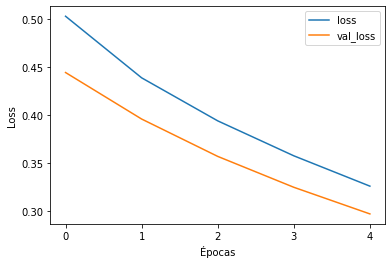

In [39]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

Plotar a Acurácia

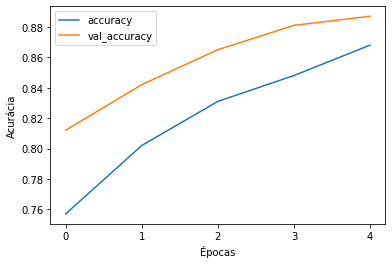

In [40]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

Aavaliar o modelo

In [41]:
# Avaliação do Modelo
val_loss, val_accuracy = model.evaluate (test_generator)
print(val_accuracy)

8/8 [==============================] - 3s 328ms/step - loss: 0.2968 - accuracy: 0.8870
0.8870000243186951


Efetuar o Fine Tuning: Congelar as camadas até a 100

In [42]:
# Efetuar o Fine Tuning
# Primeiro fazer o Transfer Learning
# Depois o Fine Tuning

# descongelar algumas camadas
base_model.trainable = True
len(base_model.layers)

# deixar o início da base
# congelar o final
fine_tuning_at = 100

for l in base_model.layers[:fine_tuning_at]:
  l.trainable = False

Compilar e Treinar o Modelo (fine tuning)

In [43]:
#compilar o modelo
# testar com o Adam tb
model.compile(optimizer = tf.keras.optimizers.RMSprop(
                                              lr=0.0001),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# Treinar o modelo
EPOCHS = 5
r = model.fit_generator(train_generator,
                        epochs = EPOCHS,
                        validation_data = test_generator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/5
16/16 [==============================] - 13s 571ms/step - loss: 0.2045 - accuracy: 0.9135 - val_loss: 0.0780 - val_accuracy: 0.9710
Epoch 2/5
16/16 [==============================] - 8s 503ms/step - loss: 0.0346 - accuracy: 0.9950 - val_loss: 0.0870 - val_accuracy: 0.9650
Epoch 3/5
16/16 [==============================] - 8s 506ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.1087 - val_accuracy: 0.9630
Epoch 4/5
16/16 [==============================] - 8s 507ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.1136 - val_accuracy: 0.9680
Epoch 5/5
16/16 [==============================] - 8s 504ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1094 - val_accuracy: 0.9680


Plotar a evolução da Loss-Function

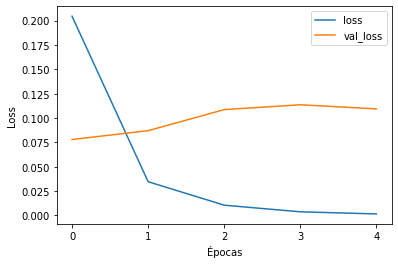

In [44]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

Plotar a evolução da Acurácia

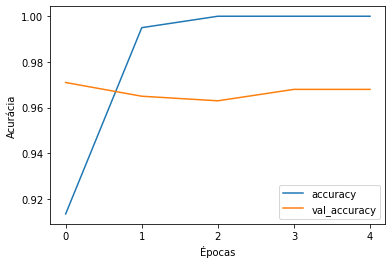

In [45]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

Avaliação do Modelo

In [46]:
# Avaliação do Modelo
val_loss, val_accuracy = model.evaluate(test_generator)
print(val_accuracy)

8/8 [==============================] - 3s 334ms/step - loss: 0.1094 - accuracy: 0.9680
0.9679999947547913


**TESTE com o optimizer ADAM**

In [47]:
#compilar o modelo
# testar com o Adam 

model.compile(
  loss="binary_crossentropy",
  optimizer="adam",
  metrics=["accuracy"]
)

# Treinar o modelo
EPOCHS = 5
r = model.fit_generator(train_generator,
                        epochs = EPOCHS,
                        validation_data = test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
16/16 [==============================] - 12s 580ms/step - loss: 0.0832 - accuracy: 0.9715 - val_loss: 0.3435 - val_accuracy: 0.9190
Epoch 2/5
16/16 [==============================] - 8s 504ms/step - loss: 0.0854 - accuracy: 0.9675 - val_loss: 0.3479 - val_accuracy: 0.9510
Epoch 3/5
16/16 [==============================] - 9s 554ms/step - loss: 0.0384 - accuracy: 0.9900 - val_loss: 0.4256 - val_accuracy: 0.9400
Epoch 4/5
16/16 [==============================] - 8s 509ms/step - loss: 0.0130 - accuracy: 0.9980 - val_loss: 0.4068 - val_accuracy: 0.9470
Epoch 5/5
16/16 [==============================] - 8s 508ms/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.3785 - val_accuracy: 0.9480


Plotar a evolução da Loss-Function

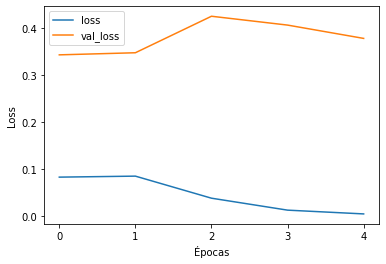

In [48]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

Plotar a evolução da Acurácia

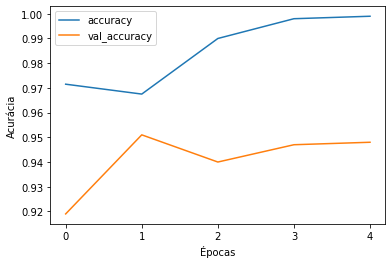

In [49]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

Avaliação do Modelo

In [50]:
# Avaliação do Modelo
val_loss, val_accuracy = model.evaluate(test_generator)
print(val_accuracy)

8/8 [==============================] - 3s 335ms/step - loss: 0.3785 - accuracy: 0.9480
0.9480000138282776


**Conclui-se que a utilização do optimizer Adam, não melhorou a avaliaçao do modelo. O opimizer "RMSprop" obteve melhores resultados para este modelo.**

**RMSprop = 0.9679999947547913**

**Adam = 0.9480000138282776**

